In [16]:
%config InlineBackend.figure_format = 'retina'
import findspark
findspark.init()

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext, Row, SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
import time
from slugify import slugify

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

In [43]:
countries = ['Germany', 'France', 'Netherlands', 'United Kingdom', 'Finland',
       'Italy', 'Spain', 'Belgium', 'Greece', 'Denmark', 'Sweden',
       'Ireland', 'Austria', 'Cyprus', 'Portugal', 'Slovakia',
       'Czech Republic', 'Poland', 'Hungary', 'Croatia']

to_build = pd.read_csv('./networks_to_build.csv')
to_build['id'] = to_build['id'].astype(str)
to_build = to_build[to_build.id != '6701738986']
to_build['co_list'] = to_build.co_list.apply(lambda x: str(x)[1:-1].split(','))
# Choose only relevant network for analysis, these with high citation degree
to_build = to_build[to_build.cited_by_count > 5000]

to_build.to_csv('./phys_ego_networks.csv')

In [36]:
asd = pd.DataFrame([{ 'first': 2, 'second': 1}, {'first': 4, 'second': 3}])


F.lit(F.struct(to_build['id'].values))

TypeError: Invalid argument, not a string or column: ['7202641523' '35380287000' '36048731400' '35354080500' '36012823000'
 '36080215500' '55429556800' '7201774556' '56466188600' '55854740500'
 '7202777700' '34573036500' '36047278500' '56210513900' '36041345700'
 '7006224498' '7202318774' '35416421800' '36076881700' '35399610800'
 '36051313500' '16471950000' '36051235900' '56597596100' '36037246700'
 '35926846100' '35403292800' '55027467100' '35926874100' '35231615000'
 '35227836300' '35351391300' '7006875836' '57050399800' '46361101700'
 '7103185149' '7101979069' '36078643000' '35227988200' '55066608000'
 '7409607221' '56212505300' '57203056792' '36044041500' '7102574024'
 '7201777137' '36078272300' '35406239400' '35308901700' '7402870125'
 '35354455800' '55169492300' '36037094600' '7201795361' '36044888200'
 '21634758500' '56623994700' '36050113100' '35227278400' '36071970300'
 '55763673600' '55536726900' '8903076100' '55172704900' '7404772262'
 '35392235500' '35479256700' '34975087600' '57203055289' '57202558736'
 '7004343357' '7103125178' '7101735283' '35377488600' '7101801755'
 '36042579800' '35227897700' '6602240294' '56438842500' '55537623600'
 '36049570700' '35227374900' '35227859100' '35379345100' '35095999100'
 '35372963400' '55429522900' '35227622600' '55154772500' '36051279500'
 '7102989379' '36047665000' '56253704800' '7007073571' '35226935900'
 '35350563300' '36040844400' '35372660600' '55423086200' '7102723796'
 '8398051000' '35226990500' '35380236300' '35379599600' '35277586500'
 '56024254100' '35354875500' '35227713900' '57202638098' '7103202523'
 '35227287700' '7201832825' '57202556932' '35227837600' '36148321100'
 '56997681700' '56672467900' '57198460575' '36048879600' '56025381300'
 '35227846600' '55324070900' '8903094300' '36077375900' '36040636300'
 '34767905500' '35495729400' '7102358027' '24430947200' '35378012400'
 '35228074900' '7102904152' '7202419956' '36041337100' '57197558715'
 '35351598200' '7102274048' '7103118190' '7004571033' '55159135900'
 '39262155100' '36040339400' '34568529500' '35227180100' '36049986500'
 '35227144500' '35227052100' '7101800587' '56448125700' '35227168100'
 '26643205000' '36040368300' '24299225600' '35227618500' '35272832300'
 '36037157800' '55254610800' '57191801446' '35277690600' '14625680200'
 '10639199500' '35227994300' '8903088900' '24076563200' '35227033500'
 '7202268530' '7006173465' '55800249300' '35227177200' '35227264600'
 '36050187000' '35227396800' '36071300500' '56866707500' '35428581800'
 '35373396900' '36013249500' '35227721200' '8065204700' '35372254600'
 '7101777373' '36039377800' '35227027600' '35230028400' '55382766900'
 '7202626958' '7007043802' '7202580243' '7005891607' '7004992352'
 '7410186688' '24755802900' '35388173900' '35511455300' '35227975600'
 '35355338200' '35274563200' '56978805100' '36038584600' '7102183906'
 '35314764300' '7004900619' '8301003700' '56808147200' '7406648031'
 '35228229300' '37036023500' '8790523400' '35227271500' '35273234200'
 '35274511200' '35227037900' '24759171600' '57201642612' '35227176800'
 '7202519228' '23494961300' '13906348600' '55730111500' '7005344981'
 '55780097500' '35227008200' '55950127500' '16020503000' '7101889523'
 '35354020600' '35227603300' '7103087478' '35226977100' '55856929200'
 '34573766600' '36041769200' '35227968200' '7202190781' '57203078900'
 '35431781900' '56042878100' '36044578700' '7007170557' '35227723000'
 '7401702536' '7103016042' '57202570778' '56029998100' '56363077100'
 '36046783700' '35227173400' '7202041613' '36489311600' '35313296500'
 '55871516700' '55412398100' '35235601700' '7102479035' '7006567214'
 '7201788288' '35226987200' '7103219883' '35226955000' '14045516300'
 '35228206500' '56438863200' '35227863300' '35228068400' '7102452820'
 '35227748400' '35313916500' '35513908800' '7101609791' '56705691500'
 '7006418936' '36048279900' '35227857000' '7005863934' '56439016700'
 '35467605800' '7004135079' '7006944872' '7003663342' '36044882000'
 '35430862300' '35227995300' '56439029400' '35227357700' '7102607898'
 '7103383475' '7101707295' '56438908200' '35227037600' '25940940600'
 '36051195700' '7103293037' '35314113500' '56321805400' '57202562075'
 '55538168200' '56448205100' '7004821600' '7005947314' '56424971500'
 '35227173600' '7102531000' '7403053729' '35274580000' '35314676600'
 '35228101100' '35227072700' '35313561200' '22996961300' '55606844200'
 '35227424900' '35227648200' '36049696300' '35227169400' '35226940800'
 '35278894500' '35461255500' '36043688000' '35227987800' '31967524300'
 '35355123900' '35227243000' '35227526500' '7006272136' '35228077300'
 '56720467600' '35227746300' '35228011700' '6603962980' '7006321472'
 '35228210800' '35227074900' '35228205600' '57203051099' '7005520224'
 '34869270300' '7005129581' '7102422627' '7403505046' '6701389778'
 '7402963940' '7006739132' '7003443189' '35376932100' '35314826300'
 '35227510800' '7006820740' '36064172000' '7004705753' '55411959900'
 '35227850200' '7004990102' '35228094600' '6701513700' '25025562700'
 '56967736500' '56448239800' '57203072655' '8790525200' '7007164627'
 '35227864300' '56439065300' '35227807300' '55538128300' '8789233700'
 '7201417070' '56448218100' '55058315300' '8748371100' '14634009700'
 '35228145300' '7202850334' '35227241600' '35221177400' '35228112900'
 '35763389500' '35227785300' '24325496700' '36040863900' '56438990000'
 '35227664800' '35227214700' '34975054600' '35227687400' '13402610900'
 '57188687200' '34882096000' '35278220700' '35228088300' '35227400700'
 '56870887100' '34569623400' '8859589200' '35227362200' '56889137700'
 '8078236300' '35227279000' '56967690900' '56275463200' '7103287561'
 '35227020800' '55666157000' '7101874441' '7101848031' '35227667600'
 '35227891800' '7006749585' '35227000800' '56448082000' '35227146300'
 '25937297400' '36040074800' '38762508700' '7203021106' '35315017000'
 '7102679861' '35315141700' '55532046200' '35227962800' '6701856410'
 '7005909244' '35227851000' '55444194400' '35228082900' '56808317900'
 '35226925100' '35226988800' '7004391239' '35227524200' '35314689300'
 '35227566400' '7005041971' '6507798874' '35278815300' '35313391900'
 '8086252800' '35277393900' '35228097800' '56029882700' '36049973800'
 '35227145000' '35313279200' '35315034700' '8791909900' '35227509400'
 '35227095300' '36039440700' '7006603224' '35222026500' '6603796638'
 '56210543200' '24764445800' '36038072700' '57042385500' '55538312300'
 '35227134400' '34572244600' '55667348900' '36050187200' '8738691400'
 '57202562722' '35227306900' '35227964000' '35227959000' '8086257600'
 '8791870700' '6701362856' '56520493200' '7005281007' '35227844500'
 '56448159500' '7003919278' '35227385300' '36170321000' '57203031981'
 '34881572300' '56978883700' '35766979100' '7007049415' '7004125229'
 '35354210300' '7004087284' '56254215400' '25942632800' '7101750622'
 '35227186000' '35227290100' '56880484900' '24483223100' '25944053400'
 '35227159800' '34869079000' '25943404000' '8546457000' '35379243200'
 '12759158300' '35277534000' '7005657775' '7004537381' '35226934500'
 '35226939400' '57202557627' '57202557646' '35227270000' '35222079700'
 '35227061700' '35227857400' '7005937977' '35227028900' '35227392400'
 '35227364000' '35227042600' '14823873000' '7005228958' '35228024100'
 '36041927900' '35226986100' '35226954200' '35228222300' '55945760400'
 '56978532600' '35227051400' '55687307900' '57203215725' '35227157500'
 '6507411761' '35227370400' '56448143800' '6603680587' '35476589900'
 '7005895860' '56978809800' '55238098100' '35227633100' '55421083400'
 '35221732700' '56220801900' '35228214000' '35227904100' '34569387400'
 '8951919500' '7006326115' '35355952300' '57202558513' '55574503700'
 '24299427000' '7103267315' '35966168300' '35226969700' '35227905200'
 '35372482100' '7202300001' '7004168189' '7004463801' '7006317965'
 '35227596300' '57202563228' '7006985177' '35227743700' '7102577657'
 '6603210566' '35227354100' '35227735600' '7003831414' '56894713500'
 '56678958000' '7102779344' '35227972900' '7004689268' '34879578900'
 '56448212300' '7006507139' '36720286300' '16197605000' '36046587800'
 '7004584169' '24536744000' '24397155800' '35235459100' '10638946300'
 '56224636200' '56450243500' '16434874400' '8083003800' '7004149934'
 '7003904703' '56978617500' '35314541700' '7006077607' '14634400100'
 '35315139400' '35227026700' '7007131716' '10040344000' '35227175400'
 '35371408000' '7102910710' '7202833074' '35277866900' '35227493600'
 '35228078600' '6603462058' '35221100800' '14056004100' '36044571800'
 '7003738522' '35555531700' '15738032200' '7004443747' '55579743500'
 '35227435300' '35315083400' '10041449300' '56978846100' '35432055700'
 '56438983300' '35226943200' '36044968500' '14719607800' '10045464600'
 '24375945000' '35228070400' '7006360645' '35227190700' '35226999000'
 '55944045000' '35314973000' '55156063200' '57034305100' '35227140200'
 '7006067236' '8644855800' '35227035800' '35224063900' '36051280800'
 '7005790889' '55169859700' '35227955300' '7006417288' '6602737140'
 '56448262200' '15841177400' '35227987700' '35278835700' '6603229529'
 '35314835800' '35227087300' '35227483400' '56284115800' '35277847900'
 '35227155800' '35271010300' '57201075299' '35285543100' '35227089900'
 '55325317300' '31967708800' '35228090900' '23025523000' '35277450300'
 '56448183900' '7005326245' '35227948700' '7004441173' '56448238300'
 '35227950900' '35227162300' '57191773533' '35313283500' '55134417500'
 '35381186500' '35227157400' '35227996100' '35227162900' '6505572367'
 '12796451700' '6602909138' '35228076600' '25940585700' '7404644927'
 '7004647768' '7005836769' '24473045500' '35232282500' '37085052200'
 '35228160000' '35227935800' '10043778500' '6603050511' '55957278700'
 '8719356400' '35227264800' '35227044300' '35227983700' '7005502556'
 '35600540200' '7102168325' '7006169903' '55660206600' '56393151400'
 '7004828916' '7202608150' '35227789000' '35373857800' '7006368713'
 '35317963900' '7102793088' '56236886700' '36045348100' '36038149900'
 '35227088300' '7101634220' '35395980800' '35421128300' '36045489100'
 '14025305900' '12758684000' '56978868600' '36040798600' '34569272800'
 '13702651800' '7102885673' '56802829900' '35446128700' '55006646100'
 '16741658400' '7006052153' '6504592246' '7102452915' '56243019300'
 '7103236448' '35373652400' '35378176800' '37092789400' '7202282304'
 '56283456000' '55520163700' '35231140700' '7202564680' '56142584700'
 '35395245000' '35547194700' '55423745000' '26643471200' '7103228850'
 '56411089100' '56808170100' '7402606754' '36049860600' '56566239800'
 '35227360800' '26326667400' '7102282953' '36045793700' '35228040900'
 '35447152000' '55663198300' '36046932600' '7007059631' '36048150200'
 '26640178500' '35502091400' '55203838700' '36042840300' '36040393500'
 '55341229300' '36043939900' '35444542200' '36046487200' '56861715700'
 '23050742800' '12754063500' '35381445900' '35444602000' '14633357600'
 '7203019014' '7006009729' '35474081900' '36042757800' '35467521800'
 '35398076400' '36044345400' '56962789600' '7005817505' '7101824094'
 '7202703236' '16180677800' '55937239600' '35374468500' '35380094100'
 '35380220500' '36050490200' '56386887800' '6701671343' '7005058956'
 '36038728300' '56488383400' '7102349252' '56576462100' '39960963300'
 '7402442071' '57201650393' '55732103600' '55702473800' '35227961200'
 '35493408400' '35446602600' '35414205100' '35569662900' '56662814100'
 '55675982000' '35375208700' '55598669000' '35417533500' '7103385099'
 '7102706884' '35426195700' '26643377500' '7006826974' '9533191200'
 '7102799259' '7101880041' '7102016311' '35371766500' '7102852402'
 '36039126400' '7103273661' '36040796700' '56431978500' '35512998100'
 '36045997500' '36051409500' '35419962500' '7404311833' '56246000100'
 '7201882795' '7401463172' '55545557400' '7102753018' '35377080700'
 '56248478800' '35453885900' '7101991490' '35401371900' '35227254100'
 '7101795724' '35494145900' '35588010400' '35228717800' '36041084100'
 '55490162700' '35556997000' '36038586400' '7102969595' '7202386332'
 '56216848900' '14054986200' '36066810100' '36038651200' '7402342563'
 '7007156174' '7102578937' '23989140600' '57203055845' '23020860700'
 '35601646300' '25647616000' '55075291000' '7006062179' '7102529229'
 '7403334992' '7006208502' '35478183900' '36043349200' '7007179429'
 '7201860833' '7404802957' '55665342200' '56217400400' '36955817700'
 '36043733600' '7102422024' '22954842600' '56468905200' '7005259503'
 '36044694400' '56978160800' '7103251673' '55416543900' '7005819296'
 '36068591400' '6506585188' '24774986400' '22981106100' '56610834700'
 '35076106000' '35407336900' '7102225410' '36040468400' '7404312372'
 '36045822400' '36067003800' '56377899900' '7202279285' '35548399100'
 '36042042600' '7007063399' '55541557500' '18037974700' '7102431876'
 '7005619547' '55542244000' '7005912361' '36038918700' '7006116543'
 '7102652689' '23005983300' '11040255900' '7004293805' '7007049752'
 '55539304100' '36038166400' '7401906664' '7006529375' '35392941900'
 '7102138516' '7003458998' '35597696900' '7005289082' '7005648889'
 '7402378359' '7402842629' '36041080300' '35227565300' '7403678691'
 '7102539039' '35570837800' '35395011200' '7005112597' '56796415500'
 '55954467200' '7102959065' '7005184741' '24070821000' '35500896800'
 '7202876234' '26643399300' '7004203473' '7007108795' '35394498800'
 '7102627598' '7406912110' '8840302400'] of type <class 'numpy.ndarray'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

In [17]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
spark = SparkSession(sqlContext)
authors = sqlContext.read.parquet('./data/authors_agg')
collaborations = sqlContext.read.parquet('./data/collaborations')
collaborations = collaborations.withColumn('published', F.to_date(F.col('published')))
collaborations = collaborations.withColumn('year', F.year(F.col('published')))
collaborations = collaborations.withColumnRenamed('author_id', 'auth_id')

In [40]:
def country_network(country):
    i_edges = sqlContext.read.parquet(os.path.abspath('./data/per_country/{}'.format(slugify(country))))
    # Select only edges between networks of most cited authors in country 
    nodes = set(i_edges.select(F.collect_set("source").alias("source")).first()["source"])
    data = i_edges.filter(i_edges.target.isin(nodes))
    
    authors_details = authors.filter(authors.id.isin(nodes)).select(authors.id, authors.country, authors.cited_by_count, authors.agg_citations)
    edges = data.groupby([i_edges.source,i_edges.target]).agg(F.sum('weight').alias('weight'), F.first('type').alias('type'))
    
    def relation_type(source, target, egos):
        etype = 'missing'
        source_is_ego = str(source) in egos
        target_is_ego = str(target) in egos
        # domestic types
        if source_is_ego and target_is_ego:
            etype = 'ego-ego'
        
        if source_is_ego and not target_is_ego:
            etype = 'ego-coauthor'
            
        if not source_is_ego and target_is_ego:
            etype = 'coauthor-ego'
        
        if not source_is_ego and not target_is_ego:
            etype = 'coauthor-coauthor'
            
        return etype
    
    def apply_relation(egos):
        return F.udf(lambda s,t: relation_type(s,t,egos), StringType())
    

    edges = edges.withColumn('relation', apply_relation(to_build['id'].values)(F.col('source'), F.col('target')))
    
    
    authpan = authors_details.toPandas()
    authpan['ego'] = authpan['id'].map(lambda x: 'Yes' if str(x) in to_build['id'].values else 'No')
    authpan['type'] = authpan['country'].map(lambda x: 'Intern' if x == country else 'Extern')
    authpan['cited_by_count'] = authpan['cited_by_count'].fillna(authpan.agg_citations).astype(int)
    authpan.drop(['agg_citations'], axis=1, inplace=True)
    
    nodes_path = './data/country_networks/{}_nodes.csv'.format(slugify(country))
    edges_path = './data/country_networks/{}_edges.csv'.format(slugify(country))
    
    authpan.to_csv(nodes_path, index=False)
    edges.toPandas().to_csv(edges_path,index=False)
    #return authpan, edges


def country_network_authors(country):
    i_edges = sqlContext.read.parquet(os.path.abspath('./data/per_country/{}'.format(slugify(country))))
    # Select only edges between networks of most cited authors in country 
    nodes = set(i_edges.select(F.collect_set("source").alias("source")).first()["source"])
    data = i_edges.filter(i_edges.target.isin(nodes))
    
    authors_details = authors.filter(authors.id.isin(nodes)).select(authors.id, authors.country, authors.cited_by_count, authors.agg_citations)
    authpan = authors_details.toPandas()
    authpan['type'] = authpan['country'].map(lambda x: 'Intern' if x == country else 'Extern')
    authpan['cited_by_count'] = authpan['cited_by_count'].fillna(authpan.agg_citations).astype(int)
    
    return authpan

def country_network_edges(country):
    i_edges = sqlContext.read.parquet(os.path.abspath('./data/per_country/{}'.format(slugify(country))))
    # Select only edges between networks of most cited authors in country 
    nodes = set(i_edges.select(F.collect_set("source").alias("source")).first()["source"])
    data = i_edges.filter(i_edges.target.isin(nodes))
    edges = data.groupby([i_edges.source,i_edges.target]).agg(F.sum('weight').alias('weight'), F.first('type').alias('type'))
    
    return edges.groupby(edges.type).agg(F.count('type').alias('count'))
    
    
def country_per_year_articles(country):
    i_edges = sqlContext.read.parquet(os.path.abspath('./data/per_country/{}'.format(slugify(country))))
    # Select only edges between networks of most cited authors in country 
    nodes = set(i_edges.select(F.collect_set("source").alias("source")).first()["source"])
    data = i_edges.filter(i_edges.target.isin(nodes))
    a_details = authors.filter(authors.id.isin(nodes)).select(authors.id, authors.country)
    author_articles = a_details.join(collaborations, a_details.id == collaborations.auth_id, 'inner') \
        .groupby([a_details.id, collaborations.year]).agg(F.count('abs_id').alias('count'))
    
    return author_articles
    
    

In [42]:
# Build csv files
#country_network('Poland')
for country in countries:
    country_network(country)

In [116]:
country_edges = pd.DataFrame(columns=['Country'])

for cny in countries:
    data = country_network_edges(cny)
    data = data.toPandas().set_index('type').T.to_dict('list')
    
    country_edges = country_edges.append({
        'Country': cny,
        'domestic': data['domestic'][0],
        'nondomestic': data['nondomestic'][0],
        'intradomestic': data['intradomestic'][0],
    },ignore_index=True)
    
country_edges

,Country,domestic,intradomestic,nondomestic
0,Germany,173034.0,120966.0,205298.0
1,France,39936.0,32528.0,94662.0
2,Netherlands,70216.0,53704.0,111096.0
3,United Kingdom,82672.0,133858.0,233235.0
4,Finland,10646.0,16680.0,31308.0
5,Italy,62018.0,48174.0,88822.0
6,Spain,7560.0,7344.0,37040.0
7,Belgium,23184.0,17860.0,29100.0
8,Greece,3692.0,5822.0,46728.0
9,Denmark,9504.0,14322.0,70414.0


In [41]:
country_data = pd.DataFrame(columns=['cited_by_count', 'country'])

for cty in countries:
    nodes = country_network_authors(cty)
    nodes['country'] = cty
    country_data = country_data.append(nodes[['cited_by_count', 'country']])

country_data.rename({'cited_by_count': 'Citations'}, inPlace=True)

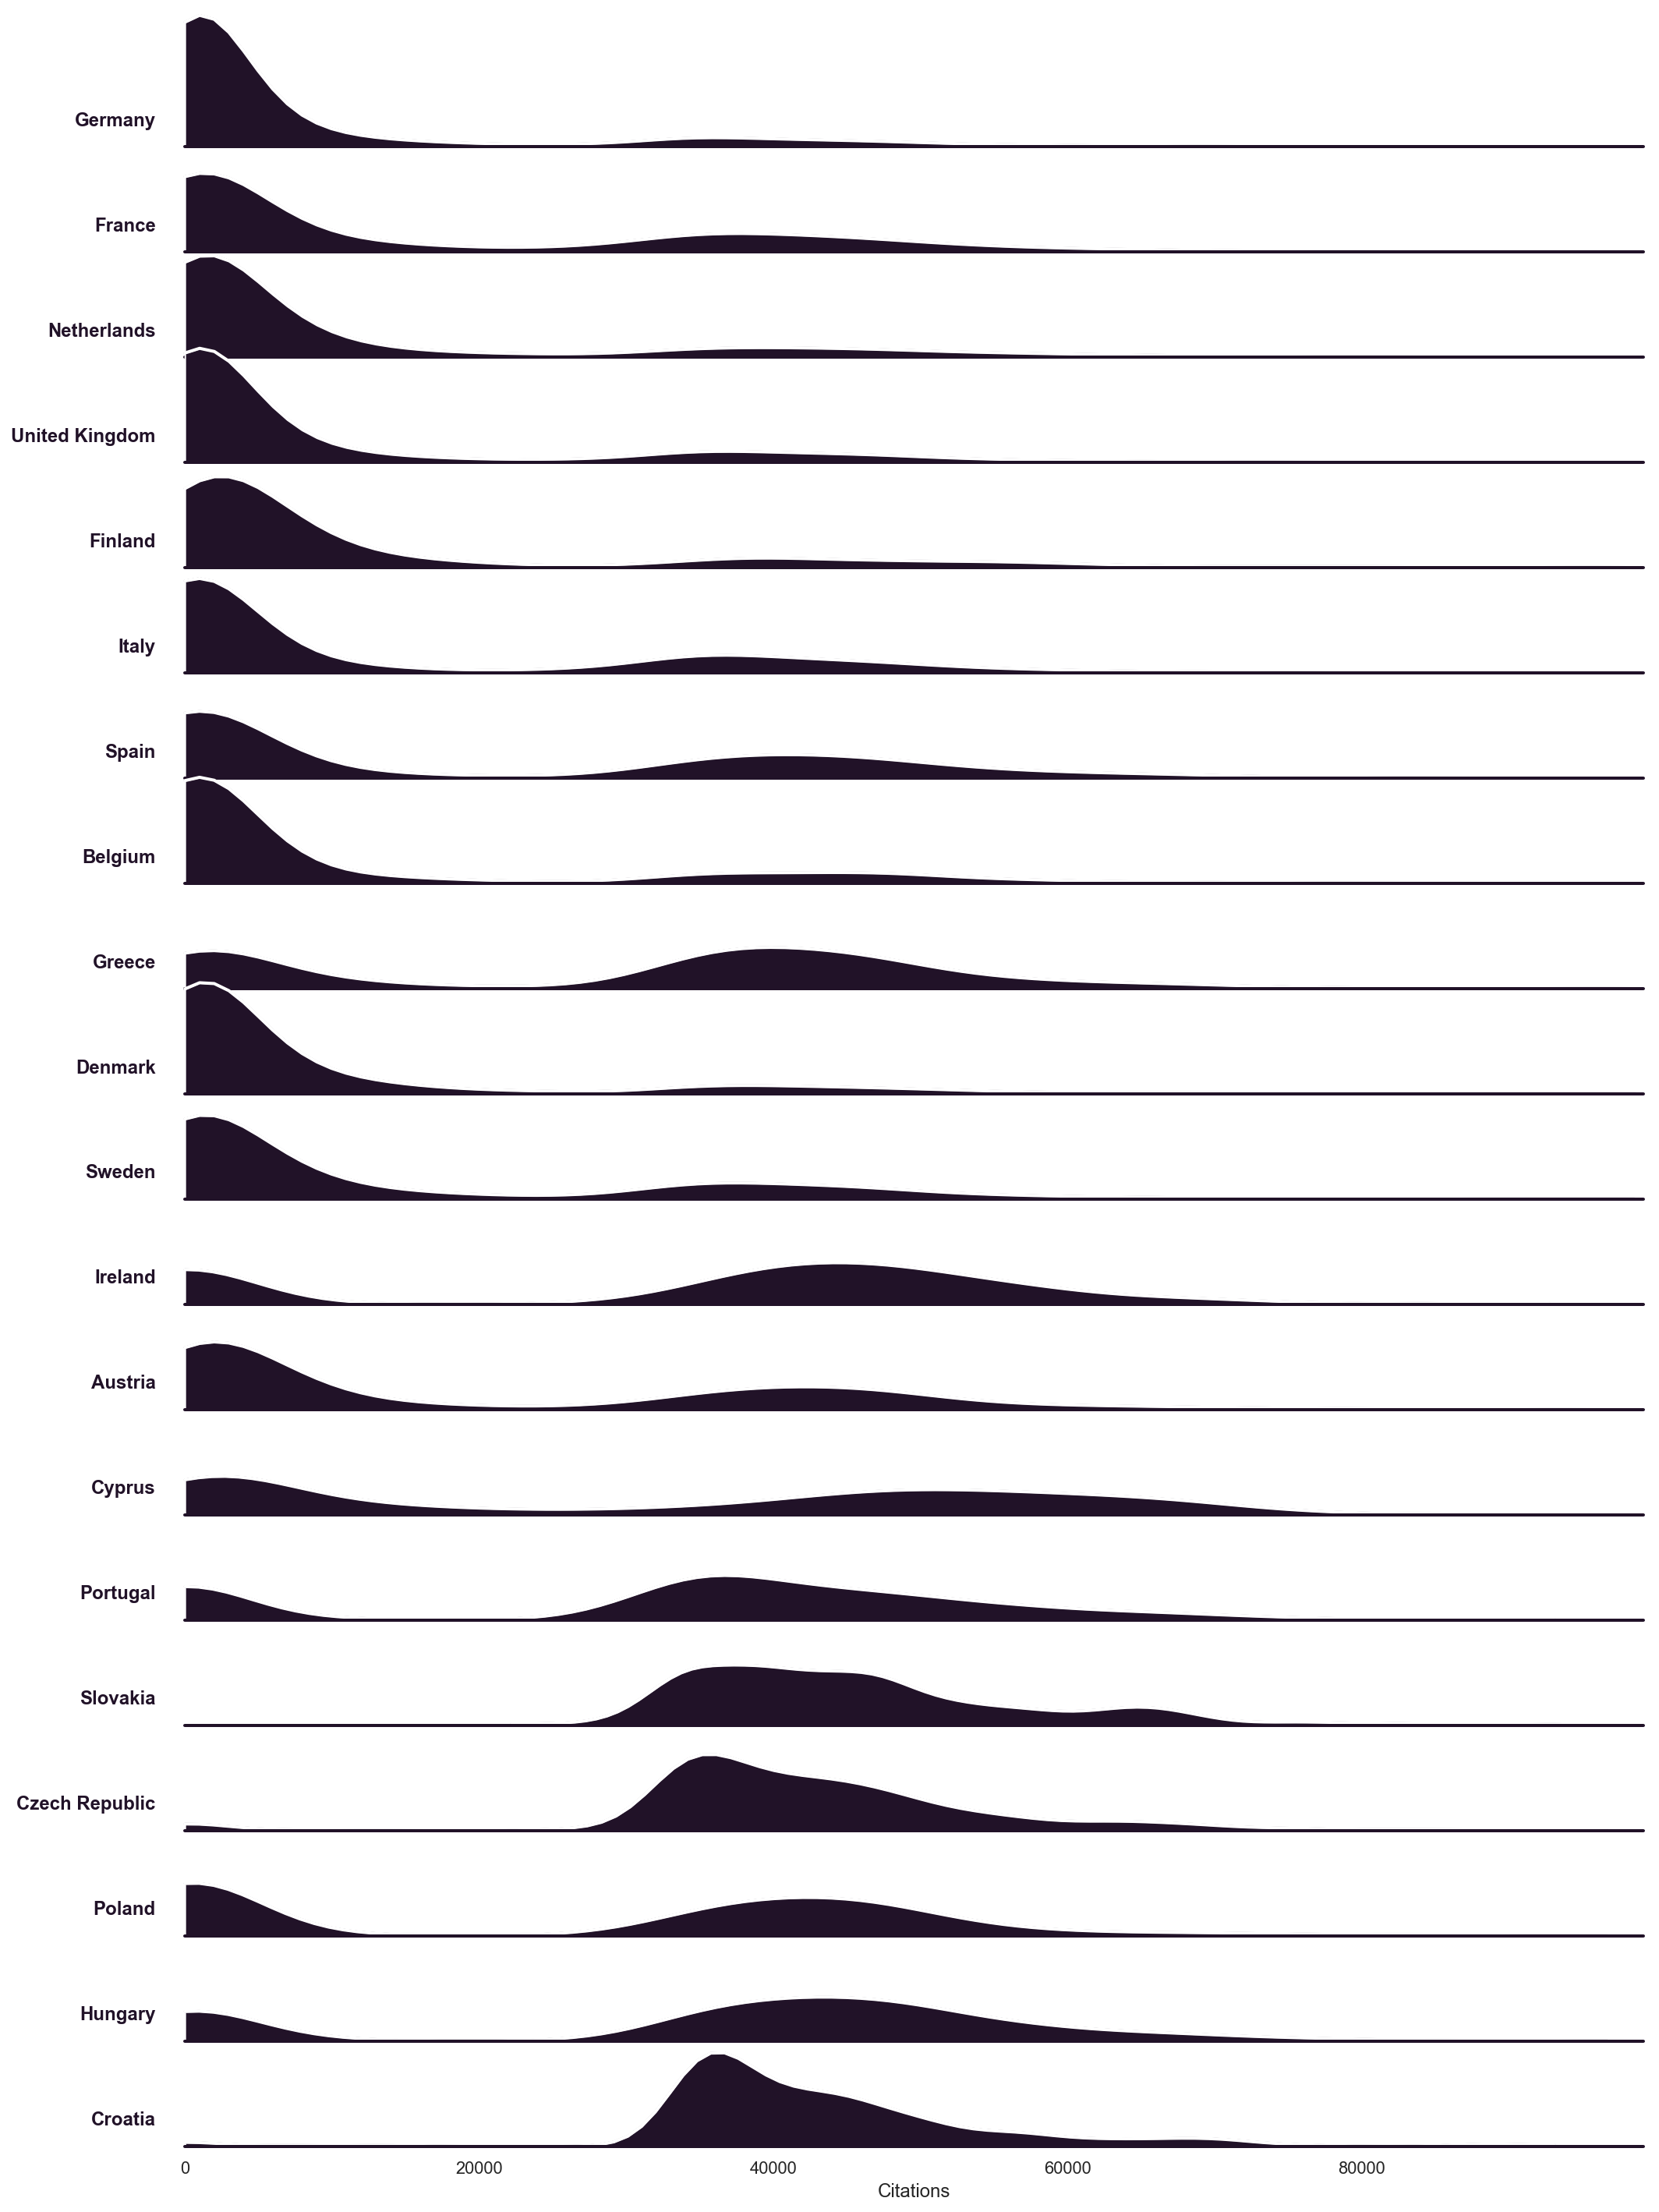

In [106]:
filtered = country_data[country_data.cited_by_count < 100000]
pal = sns.cubehelix_palette(1, rot=1, light=.1)
g = sns.FacetGrid(filtered, row="country", hue="country", aspect=15, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "cited_by_count", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "cited_by_count", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.margins(x=0, y=0) 
    ax.text(-0.02, .2, label, fontweight="bold", color=color,
            ha="right", va="center", transform=ax.transAxes)
    
g.map(label, "cited_by_count")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.20)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set_xlabels('Citations')
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.savefig("./phys_citations_densities.png", format='png', dpi=300)

In [ ]:
country_edges.to_csv('./phys_country_connections_type.csv',index=False)

In [125]:
country_per_year = pd.DataFrame(columns=['country', 'id', 'year', 'count'])

for cty in countries:
    nodes = country_per_year_articles(cty)
    nodes = nodes.toPandas()
    nodes['country'] = cty
    country_per_year = country_per_year.append(nodes[['country', 'id', 'year', 'count']])


In [8]:
# country_per_year['year'] = country_per_year['year'].fillna(0).astype(int)
# country_per_year['count'] = country_per_year['count'].astype(int)

country_per_year = pd.read_csv('./phys_country_articles.csv')
country_per_year['year'] = country_per_year['year'].fillna(0).astype(int)
country_per_year['count'] = country_per_year['count'].astype(int)

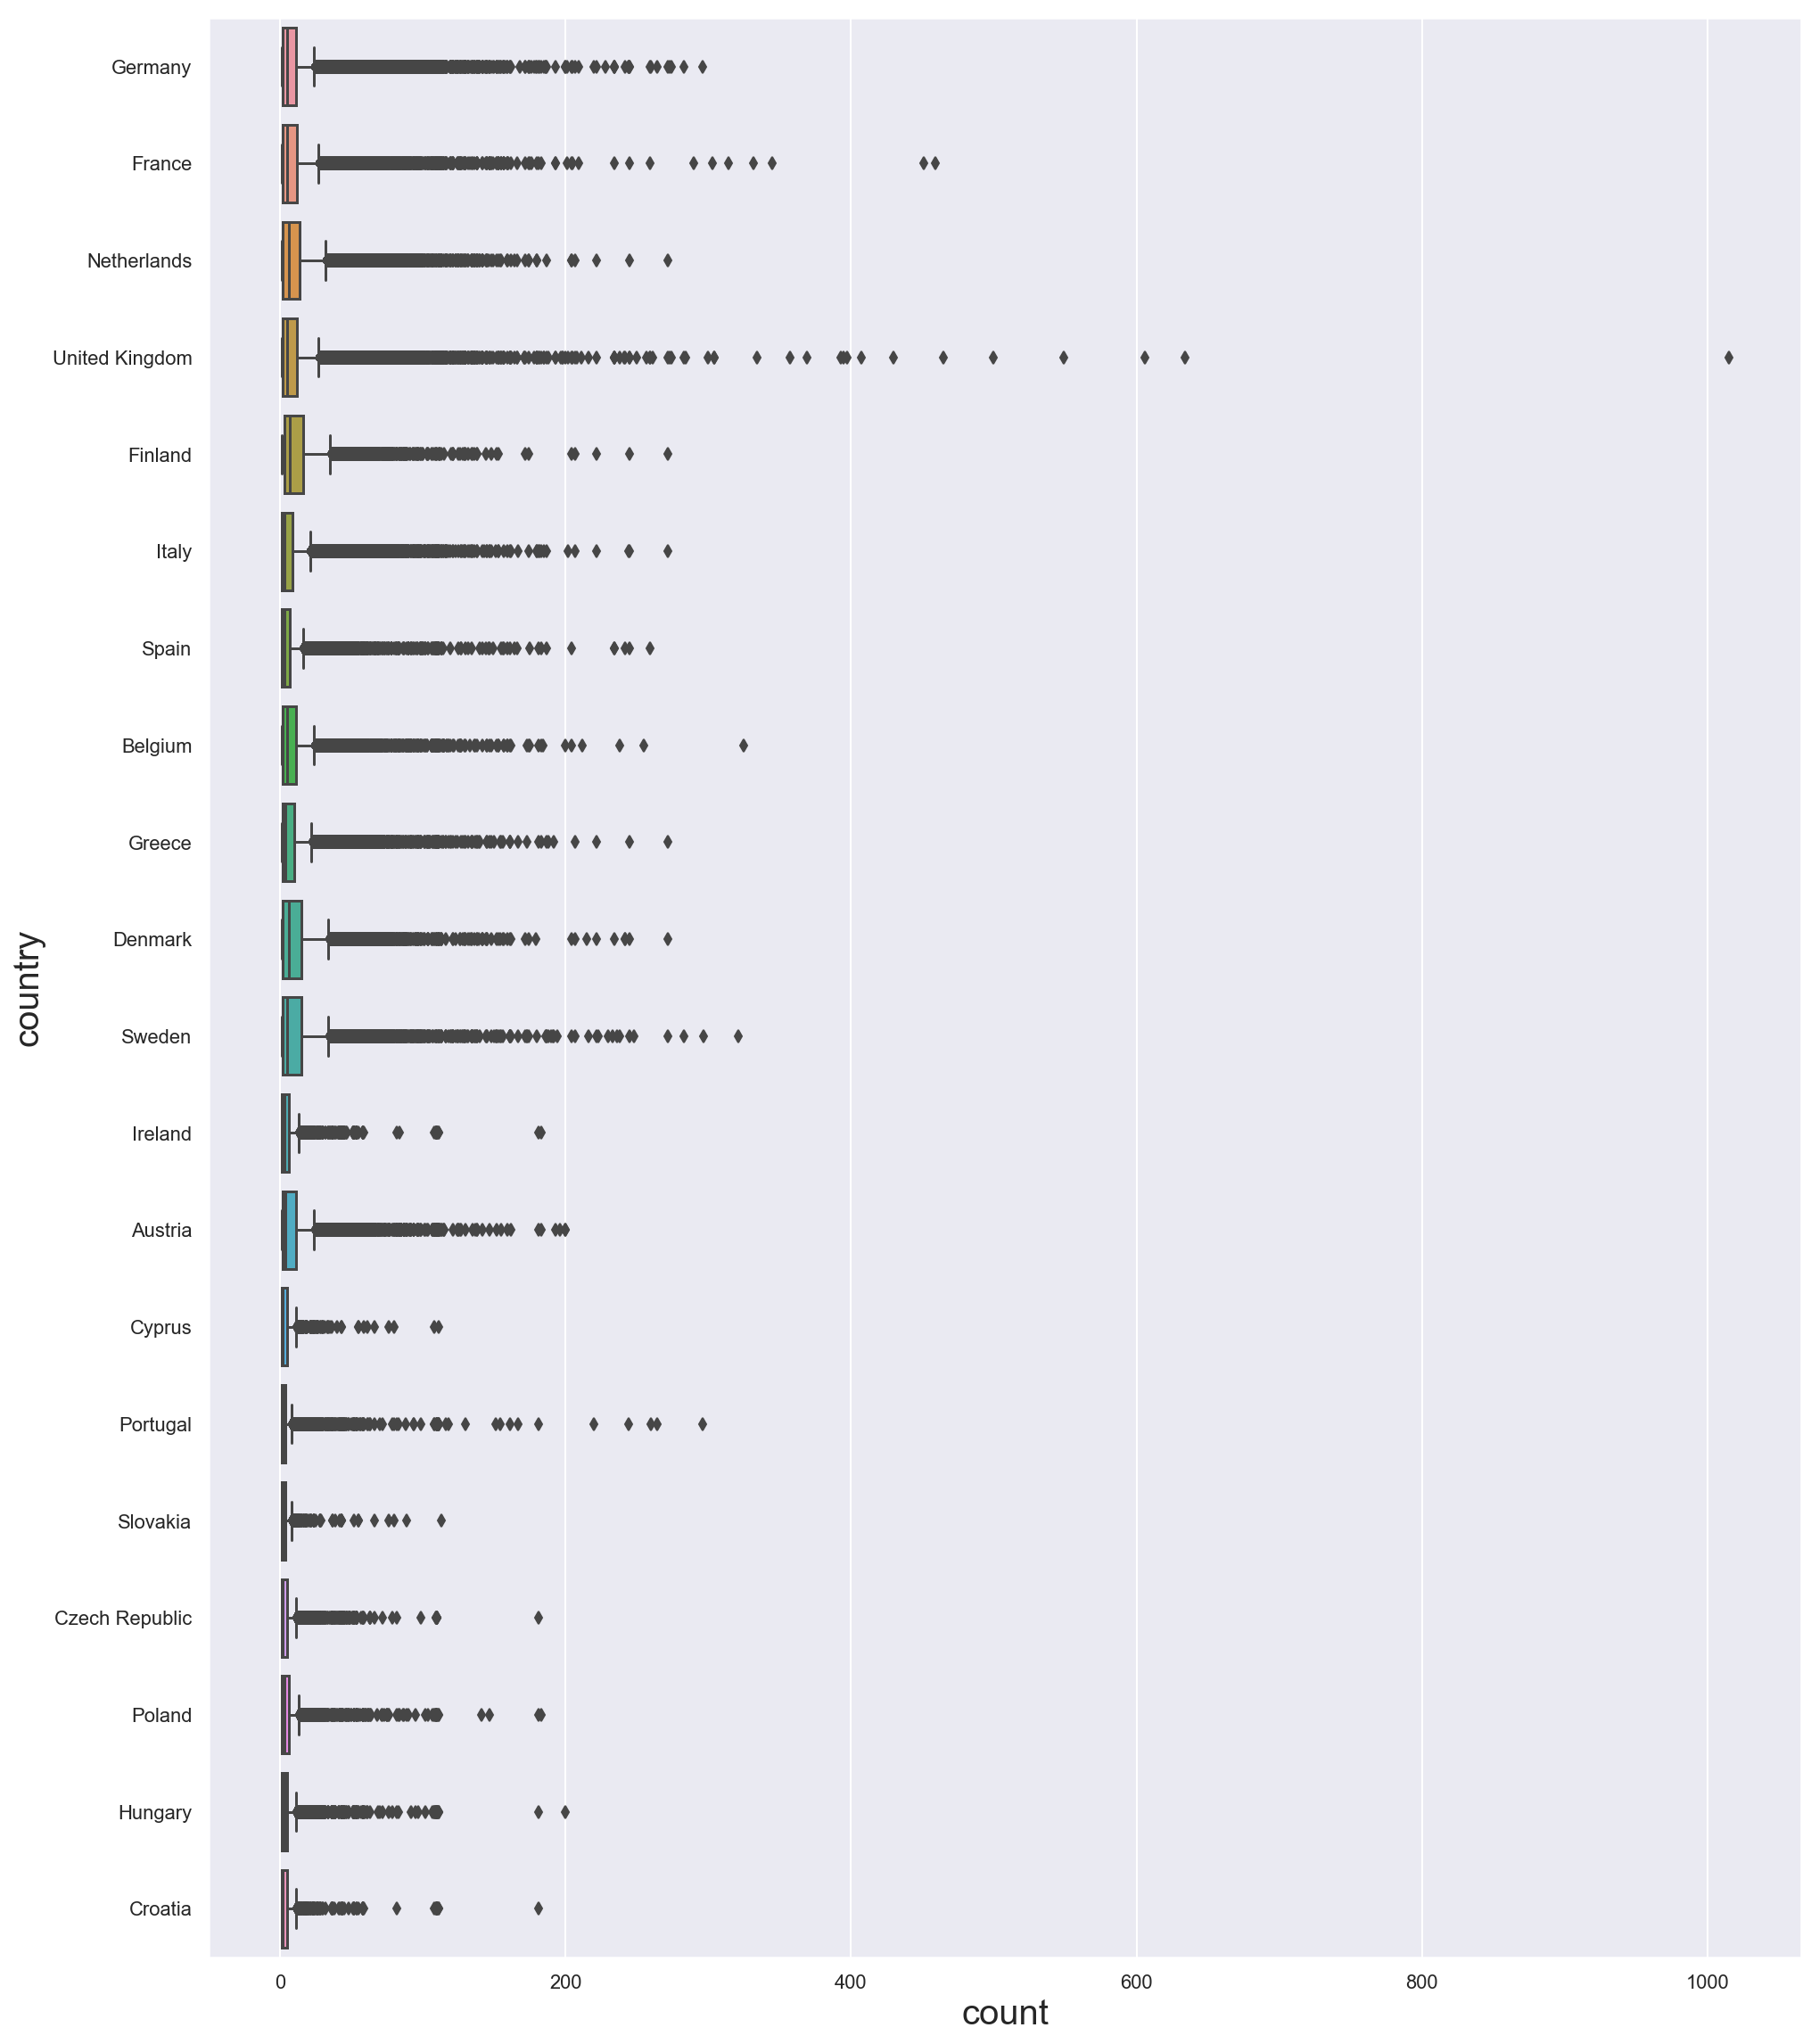

In [13]:

# to_save = country_per_year[country_per_year['year'] > 2006]
# to_save = to_save[to_save['year'] < 2018]


# to_save['year'] = to_save['year'].astype(str)
# to_save['year'] = to_save['year'].str.replace('.0', '')


# to_show = country_per_year[country_per_year.country == 'Polonia']

plt.style.use('ggplot')
sns.set(rc={
    'figure.figsize':(16,20),
    'font.size':20,
    'axes.titlesize':20,
    'axes.labelsize':20,
})


# to_show = to_show.groupby('year').agg({ 'count': 'sum' })


sns.boxplot(x="count", y="country", data=country_per_year)